# Spacecraft with reaction wheels and star tracker

Import modules and configure the notebook.

In [812]:
# Standard modules
import time
import matplotlib.pyplot as plt
import sympy as sym
import numpy as np
import control
from IPython.display import display, Markdown
import ae353_spacecraft_design as design
# My own script (an interface to the simulator)
import ae353_spacecraft_simulate

# Suppress the use of scientific notation when printing small numbers
np.set_printoptions(suppress=True)

## Create spacecraft

Create a visualizer to help with placement of reaction wheels.

In [813]:
# Create the visualizer
vis = design.create_visualizer()

# Show the visualizer in this notebook
vis.jupyter_cell()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7016/static/


Specify the location of four reaction wheels in terms of their right ascension $\alpha$ and declination $\delta$. You cannot change the number of wheels, but it is likely that you **must** change the location of wheels in order for the system to be controllable.

In [814]:
# wheels = [
#     {'alpha': 1 * np.pi / 4, 'delta': 0.},
#     {'alpha': 3 * np.pi / 4, 'delta': 0.},
#     {'alpha': 5 * np.pi / 4, 'delta': 0.},
#     {'alpha': 7 * np.pi / 4, 'delta': 0.},
# ]

# tetrahedral, not orthogonal
# wheels = [
#     {'alpha': 0, 'delta': np.arctan(1/np.sqrt(2))},   # First wheel
#     {'alpha': 2 * np.pi / 3, 'delta': np.arctan(1/np.sqrt(2))},  # Second wheel
#     {'alpha': 4 * np.pi / 3, 'delta': np.arctan(1/np.sqrt(2))},  # Third wheel
#     {'alpha': 0, 'delta': -np.arccos(1/3)},  # Fourth wheel (pointing downward)
# ]

wheels = [
    {'alpha': 0, 'delta': np.arctan(1/np.sqrt(2))},   # First wheel
    {'alpha': 2 * np.pi / 3, 'delta': np.arctan(1/np.sqrt(2))},  # Second wheel
    {'alpha': 4 * np.pi / 3, 'delta': np.arctan(1/np.sqrt(2))},  # Third wheel
    {'alpha': 0, 'delta': -np.pi / 2},  # Fourth wheel (aligned with z-axis)
]

wheels = [
    {"alpha": 0 * np.pi / 4 + np.pi / 3, "delta": np.arctan(1./np.sqrt(3))},
    {"alpha": 2 * np.pi / 3 + np.pi / 3, "delta": np.arctan(1./np.sqrt(3))},
    {"alpha": 4 * np.pi / 3 + np.pi / 3, "delta": np.arctan(1./np.sqrt(3))},
    {"alpha": 0 * np.pi / 4, "delta": -np.pi / 2},
]


Show wheels in the visualizer. You will be warned if any wheel obscures the star tracker (i.e., the "scope") or if any two wheels are too close together.

In [815]:
design.show_wheels(vis, wheels)

Create a model of the spacecraft in URDF format. This will **overwrite** the file `spacecraft.urdf` in the `urdf` directory. Also, compute the mass $m$ and inertia matrix $J$ of the spacecraft (including all the wheels). These parameters will be used later when deriving equations of motion.

In [816]:
m, J = design.create_spacecraft(wheels)

display(Markdown(
       r'$$'
    + fr'm = {sym.latex(np.round(m, decimals=2))}'
    +  r' \qquad\qquad '
    + fr'J = {sym.latex(sym.Matrix(J.round(decimals=2)))}'
    +  r'$$'
))

$$m = 19.0 \qquad\qquad J = \left[\begin{matrix}23.37 & 0.0 & 0.0\\0.0 & 23.37 & 0.0\\0.0 & 0.0 & 20.08\end{matrix}\right]$$

## Create stars

Specify the location of at most ten stars in terms of their right ascension $\alpha$ and declination $\delta$. It is likely that you **must** change the number and/or location of stars in order for the system to be observable.

In [817]:
# stars = [
#     {'alpha':  0.00, 'delta':  0.00}, # <-- To add a star, append a copy of this dict to the list. To change
#                                       #     the location of a star, change the value of alpha and delta
# ]
stars = [
    {'alpha': -0.2, 'delta': -0.2},  # Star 1
    {'alpha':  0.2, 'delta': -0.2},  # Star 2
    {'alpha': -0.2, 'delta':  0.2},  # Star 3
    {'alpha':  0.2, 'delta':  0.2},  # Star 4
    {'alpha':  0.0, 'delta': -0.3},  # Star 5 (Lower boundary)
    {'alpha':  0.0, 'delta':  0.3},  # Star 6 (Upper boundary)
    {'alpha': -0.3, 'delta':  0.0},  # Star 7 (Left boundary)
    {'alpha':  0.3, 'delta':  0.0},  # Star 8 (Right boundary)
]

r = 0.25  # Adjust the radius as needed
num_stars = 8

# Generate star positions circularly
stars = []
for i in range(num_stars):
    theta = 2 * np.pi * i / num_stars  # Angle for each star
    alpha = r * np.cos(theta)          # x-coordinate (alpha)
    delta = r * np.sin(theta)          # y-coordinate (delta)
    stars.append({'alpha': alpha, 'delta': delta})


Show where the stars will appear in the scope. The plot on the left shows $\alpha$ and $\delta$ gridelines. The plot on the right shows $y_\text{star}$ and $z_\text{star}$ gridlines.

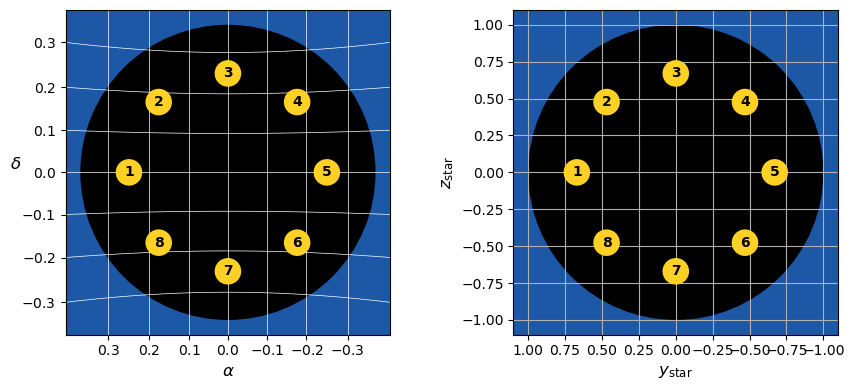

In [818]:
design.show_stars(stars)

Create a file with the location of stars. This will **overwrite** the file `stars.json` in the `urdf` directory.

In [819]:
design.create_stars(stars)

## Create dynamic model

Derive the equations of motion.

In [820]:
# Define yaw, pitch, roll angles
psi, theta, phi = sym.symbols('psi, theta, phi')

# Define angular velocities
w_x, w_y, w_z = sym.symbols('w_x, w_y, w_z')

# Define torques
tau_1, tau_2, tau_3, tau_4 = sym.symbols('tau_1, tau_2, tau_3, tau_4')

# Compute resultant torques
T1 = - tau_1 * sym.Matrix(wheels[0]['xyz']) / np.linalg.norm(wheels[0]['xyz'])
T2 = - tau_2 * sym.Matrix(wheels[1]['xyz']) / np.linalg.norm(wheels[1]['xyz'])
T3 = - tau_3 * sym.Matrix(wheels[2]['xyz']) / np.linalg.norm(wheels[2]['xyz'])
T4 = - tau_4 * sym.Matrix(wheels[3]['xyz']) / np.linalg.norm(wheels[3]['xyz'])
T = sym.nsimplify(T1 + T2 + T3 + T4)

# Define rotation matrices
Rz = sym.Matrix([[sym.cos(psi), -sym.sin(psi), 0], [sym.sin(psi), sym.cos(psi), 0], [0, 0, 1]])
Ry = sym.Matrix([[sym.cos(theta), 0, sym.sin(theta)], [0, 1, 0], [-sym.sin(theta), 0, sym.cos(theta)]])
Rx = sym.Matrix([[1, 0, 0], [0, sym.cos(phi), -sym.sin(phi)], [0, sym.sin(phi), sym.cos(phi)]])

# Define the transformation from angular velocity to angular rates
ex = sym.Matrix([[1], [0], [0]])
ey = sym.Matrix([[0], [1], [0]])
ez = sym.Matrix([[0], [0], [1]])
M = sym.simplify(sym.Matrix.hstack((Ry @ Rx).T @ ez, Rx.T @ ey, ex).inv(), full=True)

# Define euler's equations
Jx, Jy, Jz = [sym.nsimplify(j) for j in np.diag(J)]
euler = sym.Matrix([[(1 / Jx) * (T[0] + (Jy - Jz) * w_y * w_z)],
                    [(1 / Jy) * (T[1] + (Jz - Jx) * w_z * w_x)],
                    [(1 / Jz) * (T[2] + (Jx - Jy) * w_x * w_y)]])

# Define equations of motion
f = sym.simplify(sym.Matrix.vstack(M * sym.Matrix([[w_x], [w_y], [w_z]]), euler), full=True)

The equations of motion have this form:

$$\begin{bmatrix} \dot{\psi} \\ \dot{\theta} \\ \dot{\phi} \\ \dot{w_x} \\ \dot{w_y} \\ \dot{w_z} \end{bmatrix} = f\left(\psi, \theta, \phi, w_x, w_y, w_z, \tau_1, \tau_2, \tau_3, \tau_4\right).$$

Here is the function $f$:

In [821]:
f

Matrix([
[                                                                                                                                                                             (w_y*sin(phi) + w_z*cos(phi))/cos(theta)],
[                                                                                                                                                                                          w_y*cos(phi) - w_z*sin(phi)],
[                                                                                                                                                              w_x + w_y*sin(phi)*tan(theta) + w_z*cos(phi)*tan(theta)],
[-433012701892219*tau_1/23367395830000000 + 866025403784439*tau_2/23367395830000000 - 433012701892219*tau_3/23367395830000000 - 612323399573677*tau_4/233673958300000000000000000000000 + 329052083*w_y*w_z/2336739583],
[                                                                       -75000000*tau_1/2336739583 - 106057523872491*tau_2/

finding A,B:

In [822]:
f_num = sym.lambdify([psi,theta,phi,w_x,w_y,w_z,tau_1,tau_2,tau_3,tau_4],f)

#picking all eq points as zero satisfies reuquiremend of the dot terms to be zero too
psi_e = 0.
theta_e = 0.
phi_e = 0.
w_xe = 0.
w_ye = 0.
w_ze = 0.
tau_1e = 0.
tau_2e = 0.
tau_3e = 0.
tau_4e = 0.

m = sym.Matrix([psi,
                theta,
                phi,
                w_x,
                w_y,
                w_z
])

n = sym.Matrix([tau_1,
                tau_2,
                tau_3,
                tau_4
])

A_num = sym.lambdify([psi,theta,phi,w_x,w_y,w_z,tau_1,tau_2,tau_3,tau_4],f.jacobian(m))
A = A_num(0,0,0,0,0,0,0,0,0,0)

B_num = sym.lambdify([psi,theta,phi,w_x,w_y,w_z,tau_1,tau_2,tau_3,tau_4],f.jacobian(n))
B = B_num(0,0,0,0,0,0,0,0,0,0)

CONTROLLABLE?

In [823]:
W = B
shape= A.shape[0]
for i in range(1,shape):
    col= np.linalg.matrix_power(A,i)@B
    W = np.block([[W,col]])
W = W.astype(np.float64)
rank = np.linalg.matrix_rank(W)
print(shape)
print(rank)

6
6


finding K:

In [824]:
#finding K, but cant find u from here because of the sensor

import scipy.linalg
m_e = sym.Matrix([psi_e,
                theta_e,
                phi_e,
                w_xe,
                w_ye,
                w_ze
])

n_e = sym.Matrix([tau_1e,
                tau_2e,
                tau_3e,
                tau_4e
])

x = m - m_e
u = n - n_e

Q = np.diag([2, 1, 2, 1, 3, 1])
Q = np.diag([500, 500, 500, 1, 1, 1])
Q_dock = np.diag([100, 100, 100, 1, 1, 1])
R = np.diag([1,1,1,1]) * 10e-3
R_dock = np.diag([1, 1, 1, 1])
K, _, _ = control.lqr(A, B, Q, R)
K_dock, _, _ = control.lqr(A, B, Q_dock, R_dock)

eigenvalues = np.linalg.eigvals(A - B @ K)
# Check if all eigenvalues are real (zero imaginary part) and have negative real part
if np.all(np.isclose(np.imag(eigenvalues), 0)) and np.all(np.real(eigenvalues) < 0):
    # Only print K and the eigenvalues if all eigenvalues are real with negative real part
    print("All eigenvalues are real with negative real parts.")
    print("LQR Gain Matrix K:")
    print(K)
    print("Closed-loop Eigenvalues:")
    print(eigenvalues)
else:
    print("Some eigenvalues have an imaginary part or positive real part.")


Some eigenvalues have an imaginary part or positive real part.


## Create sensor model

Create symbolic variables for right ascension $\alpha$ and declination $\delta$ of each star.

In [825]:
alpha, delta = sym.symbols('alpha, delta')

Derive the sensor model for one star.

In [826]:
# Position of star in space frame
p_star_in_space = sym.Matrix([[sym.cos(alpha) * sym.cos(delta)],
                              [sym.sin(alpha) * sym.cos(delta)],
                              [sym.sin(delta)]])

# Orientation of body frame in space frame
R_body_in_space = Rz * Ry * Rx

# Position of star in body frame (assuming origin of body and space frames are the same)
p_star_in_body = R_body_in_space.T * p_star_in_space

# Position of star in image frame
r = sym.nsimplify(design.scope_radius)
p_star_in_image = (1 / r) * sym.Matrix([[p_star_in_body[1] / p_star_in_body[0]],
                                        [p_star_in_body[2] / p_star_in_body[0]]])

# Sensor model for each star
g = sym.simplify(p_star_in_image, full=True)

The sensor model has the following form:

$$\begin{bmatrix} y_\text{star} \\ z_\text{star} \end{bmatrix} = g(\psi, \theta, \phi, \alpha, \delta).$$

Here is the function $g$:

In [827]:
g

Matrix([
[21*(sin(delta)*sin(phi)*cos(theta) + sin(phi)*sin(theta)*cos(delta)*cos(alpha - psi) + sin(alpha - psi)*cos(delta)*cos(phi))/(8*(-sin(delta)*sin(theta) + cos(delta)*cos(theta)*cos(alpha - psi)))],
[21*(sin(delta)*cos(phi)*cos(theta) - sin(phi)*sin(alpha - psi)*cos(delta) + sin(theta)*cos(delta)*cos(phi)*cos(alpha - psi))/(8*(-sin(delta)*sin(theta) + cos(delta)*cos(theta)*cos(alpha - psi)))]])

All stars model:

In [828]:
# Create an empty list to store the sensor models for all stars
sensor_models = []

# Loop over each star in the stars list
for star in stars:
    alpha_val = star['alpha']
    delta_val = star['delta']
    
    # Position of star in space frame
    p_star_in_space = sym.Matrix([
        [sym.cos(alpha) * sym.cos(delta)],
        [sym.sin(alpha) * sym.cos(delta)],
        [sym.sin(delta)]
    ])
    
    # Orientation of body frame in space frame
    R_body_in_space = Rz * Ry * Rx
    
    # Position of star in body frame
    p_star_in_body = R_body_in_space.T * p_star_in_space
    
    # Position of star in image frame
    r = sym.nsimplify(design.scope_radius)  # Assuming design.scope_radius is defined
    p_star_in_image = (1 / r) * sym.Matrix([
        [p_star_in_body[1] / p_star_in_body[0]],
        [p_star_in_body[2] / p_star_in_body[0]]
    ])
    
    # Sensor model for current star
    g = sym.simplify(p_star_in_image, full=True)
    
    # Substitute the star's alpha and delta values
    g_substituted = g.subs({alpha: alpha_val, delta: delta_val})
    
    # Store the model
    sensor_models.append(g_substituted)

# sensor_models now contains the sensor models for all stars
# Stack all individual star sensor models into one vector
    g_total = sym.Matrix.vstack(*sensor_models)
    
g_total.subs([])  # sensor_models contains all individual g's
g_total

Matrix([
[                                                                                                                                                                                21*(sin(phi)*sin(theta)*cos(psi - 0.25) - sin(psi - 0.25)*cos(phi))/(8*cos(theta)*cos(psi - 0.25))],
[                                                                                                                                                                                21*(sin(phi)*sin(psi - 0.25) + sin(theta)*cos(phi)*cos(psi - 0.25))/(8*cos(theta)*cos(psi - 0.25))],
[         21*(0.984415647742286*sin(phi)*sin(theta)*cos(psi - 0.176776695296637) + 0.175857420884464*sin(phi)*cos(theta) - 0.984415647742286*sin(psi - 0.176776695296637)*cos(phi))/(8*(-0.175857420884464*sin(theta) + 0.984415647742286*cos(theta)*cos(psi - 0.176776695296637)))],
[         21*(0.984415647742286*sin(phi)*sin(psi - 0.176776695296637) + 0.984415647742286*sin(theta)*cos(phi)*cos(psi - 0.176776695296637) + 0.17585742088446

In [829]:


g_e = g_total.subs([(phi,phi_e),(theta,theta_e),(psi,psi_e)])
g_e = np.array(g_e).flatten()
g_e = g_e.astype(float)

g_e.shape
g_e


array([ 0.67027254,  0.        ,  0.46893376,  0.47635748,  0.        ,
        0.67027254, -0.46893376,  0.47635748, -0.67027254,  0.        ,
       -0.46893376, -0.47635748, -0.        , -0.67027254,  0.46893376,
       -0.47635748])

find C: and y

In [830]:
g_num = sym.lambdify([psi,theta,phi],g_total)
C_num = sym.lambdify([psi,theta,phi],g_total.jacobian(x))
C = C_num(0,0,0)
C = C.astype(float)

C.shape

(16, 6)

observable?

In [831]:
#observable?
import numpy as np

# Initialize observability matrix with the first row being C
W_c = C
shape = A.shape[0]  # Number of states

# Build the observability matrix iteratively
for i in range(1, shape):
    row = C @ np.linalg.matrix_power(A, i)
    W_c = np.block([[W_c], [row]])  # Stack new rows

# Convert to float for numerical stability
W_c = W_c.astype(np.float64)

# Compute rank
rank_O = np.linalg.matrix_rank(W_c)

# Print results
print("Number of states (n):", shape)
print("Rank of Observability Matrix:", rank_O)

if rank_O == shape:
    print("The system is OBSERVABLE.")
else:
    print("The system is NOT OBSERVABLE.")


Number of states (n): 6
Rank of Observability Matrix: 6
The system is OBSERVABLE.


LQR to find L:
    $Q_o$ must be a square $n_y \times n_y$ matrix where $n_y$ is the length of $y$\
     $R_o$ must be a square $n_x \times n_x$ matrix where $n_x$ is the length of $x$

In [832]:
from scipy import linalg

Q_o = np.diag([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
R_o = np.diag([1, 1, 1, 1, 1, 1]) * 10e-2

Lt, _, _ = (control.lqr(A.T, C.T, np.linalg.inv(R_o), np.linalg.inv(Q_o)))
L = Lt.T

print("Observer Gain Matrix L:")
print(L)
print(f'\np_o:\n{linalg.eigvals(A - L @ C)}')



Observer Gain Matrix L:
[[-1.19975688 -0.         -1.16226532 -0.03651305 -1.1263213   0.
  -1.16226532  0.03651305 -1.19975688  0.         -1.16226532 -0.03651305
  -1.1263213  -0.         -1.16226532  0.03651305]
 [-0.          1.12574543  0.03649439  1.16281756  0.          1.19914347
  -0.03649439  1.16281756 -0.          1.12574543  0.03649439  1.16281756
  -0.          1.19914347 -0.03649439  1.16281756]
 [-0.         -1.29311106  0.91900397 -0.90468189  1.29311106 -0.
   0.91900397  0.90468189 -0.          1.29311106 -0.91900397  0.90468189
  -1.29311106  0.         -0.91900397 -0.90468189]
 [-0.         -1.11956135  0.79566354 -0.78326364  1.11956135 -0.
   0.79566354  0.78326364 -0.          1.11956135 -0.79566354  0.78326364
  -1.11956135  0.         -0.79566354 -0.78326364]
 [ 0.          1.08202736  0.03507714  1.1176598  -0.          1.152575
  -0.03507714  1.1176598   0.          1.08202736  0.03507714  1.1176598
   0.          1.152575   -0.03507714  1.1176598 ]
 [-1.153

Create an instance of the `Simulator` class, which is an interface to the [pybullet](http://pybullet.org) simulation engine.

Here are two rules of thumb about the `display` argument:
* When doing development, turn the display on (`display=True`).
* When collecting data or saving a video, turn the display off (`display=False`).

If you are having trouble with the in-browser display — e.g., if it is running slowly on your laptop — then you can try the pybullet display instead (`display=False` and `display_pybullet=True`).

The `seed` argument (an integer, default `None`) initializes the random number generator that is used by the simulator.

In [833]:
simulator = ae353_spacecraft_simulate.Simulator(
    display=False,
    seed=None,
)

argv[0]=


Choose a camera view from the following options:

* `camera_sideview()`
* `camera_scopeview()`
* `camera_catview()`

In [834]:
simulator.camera_sideview()

In [835]:
m_e = sym.Matrix([psi_e,
                theta_e,
                phi_e,
                w_xe,
                w_ye,
                w_ze
])

n_e = sym.Matrix([tau_1e,
                tau_2e,
                tau_3e,
                tau_4e
])

Define a controller that maps sensor measurements to actuator commands. By default, it applies zero torque to each reaction wheel. Modify the `run` function to make the controller behave differently. This function will be called 25 times per second (i.e., at 25 Hz) by the simulator.

In [836]:
class Controller:
    def __init__(self,K,L,A,B,C,psi_e,theta_e,phi_e,w_xe,w_ye,w_ze,tau_1e,tau_2e,tau_3e,tau_4e,g_e):
        # FIXME: add class variable names to this list (e.g., 'xhat')
        # if you want these variables to be logged by the simulator
        # self.variables_to_log = []
        self.K = K
        self.K_dock = K_dock
        self.L = L
        self.A = A
        self.B = B
        self.C = C
        self.psi_e = psi_e
        self.theta_e  = theta_e
        self.phi_e = phi_e
        self.w_xe = w_xe
        self.w_ye = w_ye
        self.w_ze = w_ze
        self.tau_1e = tau_1e
        self.tau_2e = tau_2e
        self.tau_3e = tau_3e
        self.tau_3e = tau_3e
        self.x = x
        self.n_e = n_e
        self.dt = 0.01
        self.g_e =  g_e
    def reset(self):
        self.xhat = np.array([0.,
                              0.,
                              0.,
                              0.,
                              0.,
                              0.])
    
    def run(self, t, star_measurements):
        """
        The variable t is the current time.

        The variable star_measurements is a 1d array of length twice the
        number N of stars:

            [y_1, z_1, y_2, z_2, ..., y_N, z_N]
        
        The image coordinates y_i and z_i of the i'th star (for i = 1, ..., N)
        are at index 2 * i - 2 and 2 * i - 1 of this array, respectively.
        """
    

        # FIXME: replace the following lines
        u = -self.K @ self.xhat
        
        # y = self.C @ self.x - star_measurements
        y = star_measurements - self.g_e
        # y = self.C @ self.x
        self.xhat += self.dt * (self.A@self.xhat + self.B @ u - self.L@(self.C@self.xhat-y))
        
        tau = u

        torque_1 = tau[0]
        torque_2 = tau[1]
        torque_3 = tau[2]
        torque_4 = tau[3]
        return torque_1, torque_2, torque_3, torque_4

Create an instance of the controller.

In [837]:
controller = Controller(K,L,A,B,C,psi_e,theta_e,phi_e,w_xe,w_ye,w_ze,tau_1e,tau_2e,tau_3e,tau_4e,g_e)

You could reset the simulator with given initial conditions.

In [838]:
simulator.reset(
    initial_conditions={
        'psi': 0.,
        'theta': 0.,
        'phi': 0.,
        'w_x': 0.,
        'w_y': 0.,
        'w_z': 0.,
    },
    scope_noise=0.1,        # <-- standard deviation of each image coordinate of each star tracker measurement
    space_debris=True,      # <-- whether or not there is space debris
    docking_time=60.        # <-- how long it takes for the space-cat to dock with the spacecraft
)

Iterations (100 simulations)

In [ ]:
def iterate(num_simulations):
    success_count = 0
    for i in range(num_simulations):
        simulator.reset(
            initial_conditions=None,
            scope_noise=0.1,        # <-- standard deviation of each image coordinate of each star tracker measurement
            space_debris=True,      # <-- whether or not there is space debris
            docking_time=60.        # <-- how long it takes for the space-cat to dock with the spacecraft
        )
        controller.reset()
        data = simulator.run(
            controller,           # <-- required (an instance of your Controller class)
            max_time=65.0,         # <-- optional (how long you want to run the simulation in seconds)
            data_filename=None,   # <-- optional (name of file to which you want data saved, e.g., 'my_data.json')
            video_filename=None,  # <-- optional (name of file to which you want video saved, e.g., 'my_video.mov')
            print_debug=False,    # <-- optional (whether to print debug text - this is recommended when saving video)
        )
        has_docked = simulator.has_docked()
        if has_docked:
            print(f'{i} The space-cat docked.')
            success_count += 1
        else:
            print(f'{i} The space-cat did not dock.')
    print(f"Percent success rate: {success_count / num_simulations}")

iterate(100)

The space-cat docked.
The space-cat docked.
The space-cat docked.
The space-cat did not dock.
The space-cat docked.
The space-cat docked.
The space-cat docked.
The space-cat docked.
The space-cat docked.
The space-cat docked.
The space-cat docked.
The space-cat docked.
The space-cat docked.
The space-cat docked.
The space-cat docked.
The space-cat docked.
The space-cat docked.
The space-cat docked.
The space-cat docked.
The space-cat docked.
The space-cat docked.
The space-cat docked.
The space-cat docked.
The space-cat docked.
The space-cat did not dock.
The space-cat docked.
The space-cat docked.
The space-cat did not dock.
The space-cat docked.
The space-cat docked.
The space-cat docked.
The space-cat docked.
The space-cat docked.
The space-cat docked.
The space-cat docked.
The space-cat docked.
The space-cat docked.
The space-cat docked.
The space-cat docked.
The space-cat docked.
The space-cat docked.
The space-cat did not dock.
The space-cat did not dock.
The space-cat docked.
Th

Or, you could reset the simulator with initial conditions sampled at random (in particular, each initial condition will be sampled from a normal distribution that has mean $\mu=0.0$ and standard deviation $\sigma = 0.1$).

In [840]:
simulator.reset(
    initial_conditions=None,
    scope_noise=0.1,        # <-- standard deviation of each image coordinate of each star tracker measurement
    space_debris=True,      # <-- whether or not there is space debris
    docking_time=60.        # <-- how long it takes for the space-cat to dock with the spacecraft
)

Reset the controller.

In [841]:
controller.reset()

Run the simulator. It will quit when one of the following conditions is satisfied:

* Any star goes out of view of the scope.
* Any reaction wheel has angular velocity exceeding +/- 50 rad/s.
* The maximum time is reached.

In [842]:
data = simulator.run(
    controller,           # <-- required (an instance of your Controller class)
    max_time=70.0,         # <-- optional (how long you want to run the simulation in seconds)
    data_filename=None,   # <-- optional (name of file to which you want data saved, e.g., 'my_data.json')
    video_filename=None,  # <-- optional (name of file to which you want video saved, e.g., 'my_video.mov')
    print_debug=False,    # <-- optional (whether to print debug text - this is recommended when saving video)
)

Check if the space-cat has docked.

In [843]:
has_docked = simulator.has_docked()
if has_docked:
    print('The space-cat docked.')
else:
    print('The space-cat did not dock.')

The space-cat did not dock.


Get, show, and save a snapshot of the simulation after the last time step.

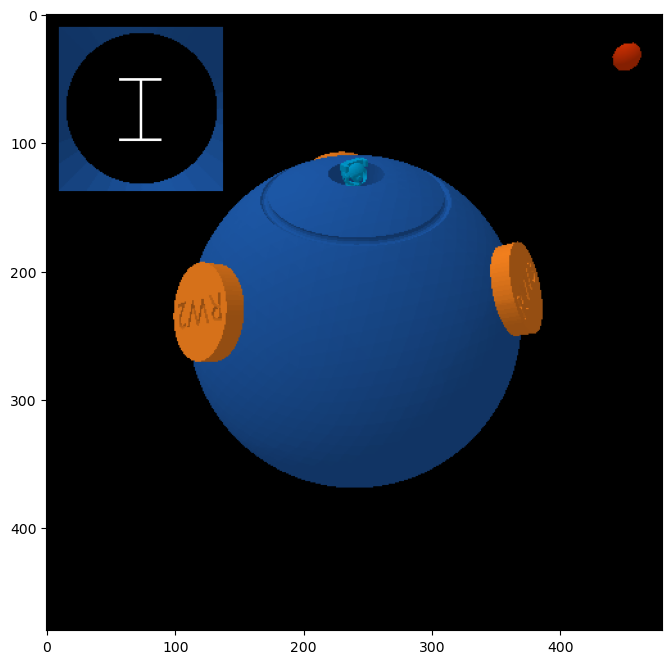

In [844]:
# Get snapshot as height x width x 4 numpy array of RGBA values
rgba = simulator.snapshot()

# Display snapshot
plt.figure(figsize=(8, 8))
plt.imshow(rgba)

# Save snapshot
plt.imsave('my_snapshot.png', rgba)

Get, show, and save a snapshot of the simulation from a side view, with a picture-in-picture view from the scope.

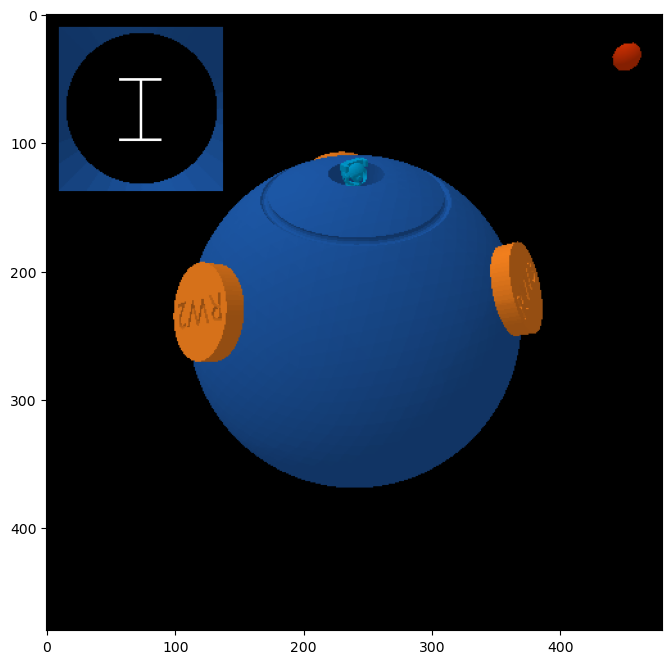

In [845]:
# Get snapshot as height x width x 4 numpy array of RGBA values
# with a picture-in-picture view of the scope
rgba = simulator.pybullet_snapshot()

# Display snapshot
plt.figure(figsize=(8, 8))
plt.imshow(rgba)

# Save snapshot
plt.imsave('my_snapshot.png', rgba)

Plot the results. (This code is meant only for development. You will want to create different and better plots for your own report.)

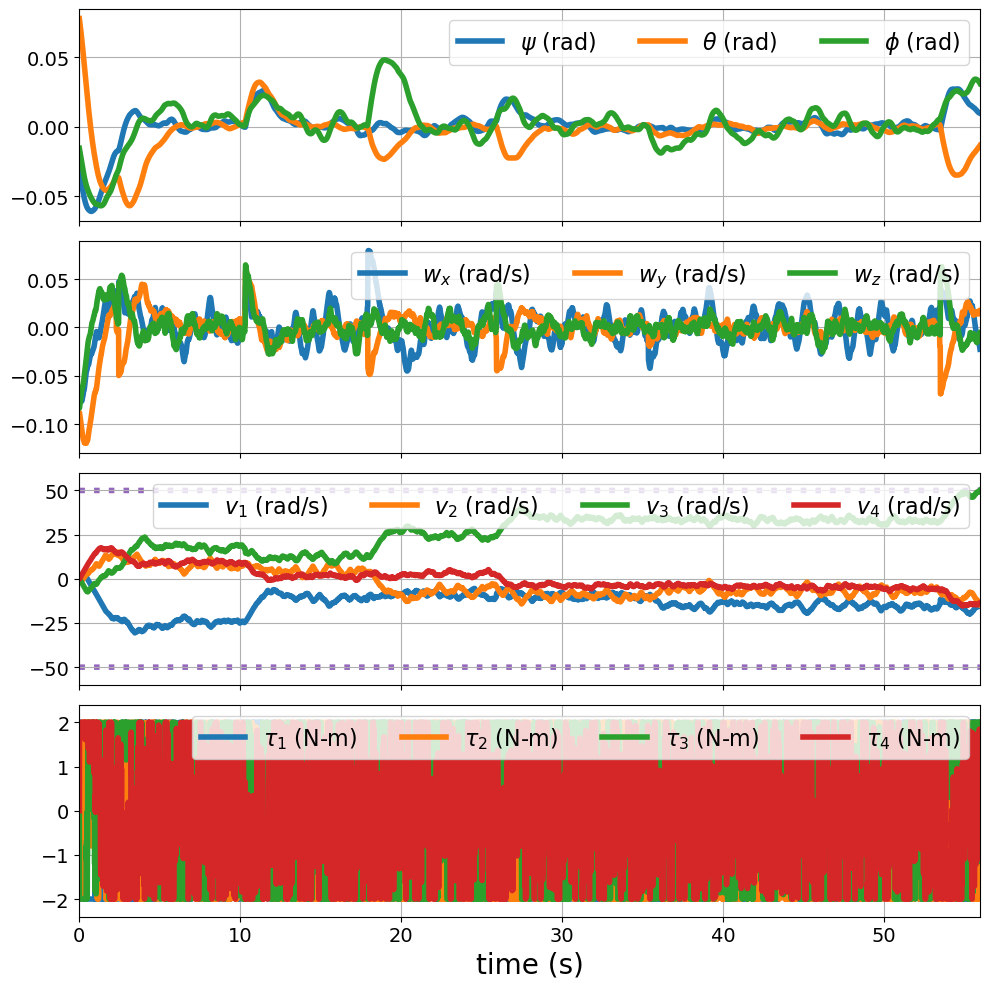

In [846]:
# Create a figure with three subplots, all of which share the same x-axis
fig, (ax_ori, ax_vel, ax_rwvel, ax_rwtau) = plt.subplots(4, 1, figsize=(10, 10), sharex=True)

# Plot yaw, pitch, roll angles
ax_ori.plot(data['t'], data['psi'], label=r'$\psi$ (rad)', linewidth=4)
ax_ori.plot(data['t'], data['theta'], label=r'$\theta$ (rad)', linewidth=4)
ax_ori.plot(data['t'], data['phi'], label=r'$\phi$ (rad)', linewidth=4)
ax_ori.grid()
ax_ori.legend(fontsize=16, ncol=3, loc='upper right')
ax_ori.tick_params(labelsize=14)

# Plot x, y, z components of angular velocity
ax_vel.plot(data['t'], data['w_x'], label=r'$w_x$ (rad/s)', linewidth=4)
ax_vel.plot(data['t'], data['w_y'], label=r'$w_y$ (rad/s)', linewidth=4)
ax_vel.plot(data['t'], data['w_z'], label=r'$w_z$ (rad/s)', linewidth=4)
ax_vel.grid()
ax_vel.legend(fontsize=16, ncol=3, loc='upper right')
ax_vel.tick_params(labelsize=14)

# Plot angular velocity of each reaction wheel
ax_rwvel.plot(data['t'], data['wheel_1_velocity'], label=r'$v_1$ (rad/s)', linewidth=4)
ax_rwvel.plot(data['t'], data['wheel_2_velocity'], label=r'$v_2$ (rad/s)', linewidth=4)
ax_rwvel.plot(data['t'], data['wheel_3_velocity'], label=r'$v_3$ (rad/s)', linewidth=4)
ax_rwvel.plot(data['t'], data['wheel_4_velocity'], label=r'$v_4$ (rad/s)', linewidth=4)
ax_rwvel.plot(
    data['t'], np.ones_like(data['t']) * simulator.v_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_rwvel.plot(
    data['t'], -np.ones_like(data['t']) * simulator.v_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_rwvel.grid()
ax_rwvel.legend(fontsize=16, ncol=4, loc='upper right')
ax_rwvel.tick_params(labelsize=14)
ax_rwvel.set_ylim(-1.2 * simulator.v_max, 1.2 * simulator.v_max)

# Plot torque applied to each reaction wheel
ax_rwtau.plot(data['t'], data['torque_1'], label=r'$\tau_1$ (N-m)', linewidth=4)
ax_rwtau.plot(data['t'], data['torque_2'], label=r'$\tau_2$ (N-m)', linewidth=4)
ax_rwtau.plot(data['t'], data['torque_3'], label=r'$\tau_3$ (N-m)', linewidth=4)
ax_rwtau.plot(data['t'], data['torque_4'], label=r'$\tau_4$ (N-m)', linewidth=4)
ax_rwtau.plot(
    data['t'], np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_rwtau.plot(
    data['t'], -np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_rwtau.grid()
ax_rwtau.legend(fontsize=16, ncol=4, loc='upper right')
ax_rwtau.tick_params(labelsize=14)


# Set x-axis properties (only need to do this on the last
# subplot since all subplots share the same x-axis)
ax_rwtau.set_xlabel('time (s)', fontsize=20)
ax_rwtau.set_xlim([data['t'][0], data['t'][-1]])
ax_rwtau.set_ylim(-1.2 * simulator.tau_max, 1.2 * simulator.tau_max)

# Make the arrangement of subplots look nice
fig.tight_layout()

Save the figure (without transparent background).

In [847]:
fig.savefig('my_figure.png', facecolor='white', transparent=False)

Plot star positions in image. This is not necessarily a useful thing to plot. The point is to show how to access measurements of star position from logged data.

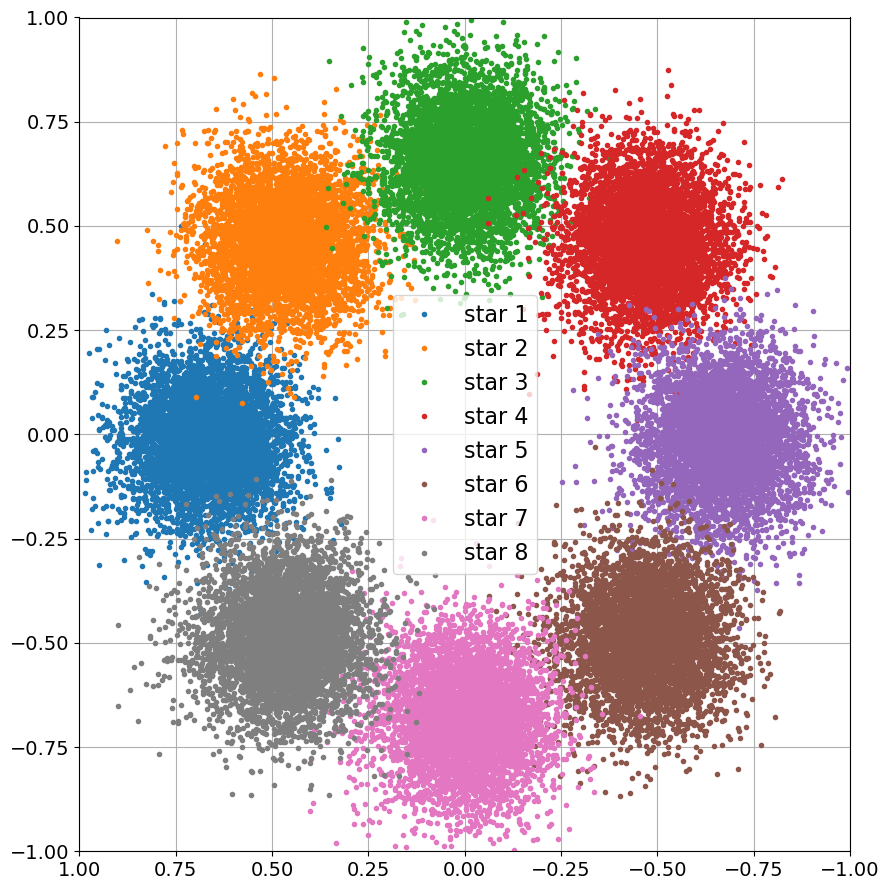

In [848]:
# Create a figure with one subplots
fig, ax = plt.subplots(1, 1, figsize=(9, 9))

# Scatter-plot the position of all stars at all time steps in the scope
for i in range(len(simulator.stars)):
    y = data['star_meas'][:, 2 * i]
    z = data['star_meas'][:, 2 * i + 1]
    ax.plot(y, z, label=f'star {i + 1}', linestyle='none', marker='.', markersize=6)

# Change appearance of axes
ax.grid()
ax.legend(fontsize=16)
ax.tick_params(labelsize=14)
ax.set_xlim(1., -1.) # <-- the "y_star" axis points left (not right)
ax.set_ylim(-1., 1.) # <-- the "z_star" axis points up

# Make the arrangement of subplots look nice
fig.tight_layout()